In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

## Load and visuallize data

In [35]:
df_train = pd.read_csv(r"C:\mydata\G8Vitamin\data\final\08062025\processed_train.csv")
df_test = pd.read_csv(r"C:\mydata\G8Vitamin\data\final\08062025\processed_test.csv")

In [36]:
columns_remove = [
    'VitaminD',
    'YearStart',
]

In [37]:
df_train = df_train[df_train['milk_consumption']<=3]
df_test = df_test[df_test['milk_consumption']<=3]

In [38]:
df_train.drop(columns=columns_remove, inplace=True)
df_test.drop(columns=columns_remove, inplace=True)

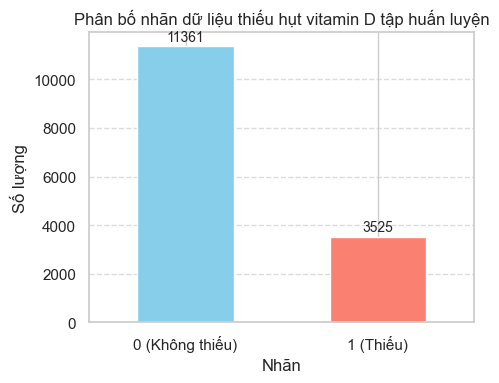

In [39]:
import matplotlib.pyplot as plt

# Count the labels
label_counts = df_train['label'].value_counts()

# Plot
plt.figure(figsize=(5, 4))
bars = label_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add numbers on top of bars
for i, count in enumerate(label_counts):
    plt.text(i, count + max(label_counts) * 0.01, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Phân bố nhãn dữ liệu thiếu hụt vitamin D tập huấn luyện')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks(ticks=[0, 1], labels=['0 (Không thiếu)', '1 (Thiếu)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


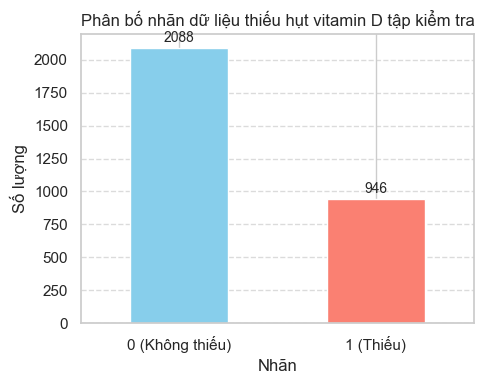

In [40]:
import matplotlib.pyplot as plt

# Count the labels
label_counts = df_test['label'].value_counts()

# Plot
plt.figure(figsize=(5, 4))
bars = label_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add numbers on top of bars
for i, count in enumerate(label_counts):
    plt.text(i, count + max(label_counts) * 0.01, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Phân bố nhãn dữ liệu thiếu hụt vitamin D tập kiểm tra')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks(ticks=[0, 1], labels=['0 (Không thiếu)', '1 (Thiếu)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
category_columns = [
    'Gender','SmokeFam' ,'Race', 'label','milk_consumption','familysize'
]

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Copy and drop categorical columns
df_scaled = df_train.copy()
df_scaled.drop(columns=category_columns, inplace=True)

# Get the number of plots and define grid size
num_cols = len(df_scaled.columns)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

# Create a large figure with subplots
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Set Seaborn style
sns.set(style="whitegrid")

# Plot each feature in a subplot
for idx, col in enumerate(df_scaled.columns):
    ax = axes[idx]
    sns.histplot(df_scaled[col].dropna(), bins=50, kde=True, ax=ax, color='skyblue', edgecolor='black')
    
    min_val = df_scaled[col].min()
    max_val = df_scaled[col].max()
    ax.plot([], [], ' ', label=f"Min: {min_val:.2f} | Max: {max_val:.2f}")
    ax.legend(loc='upper right')
    
    ax.set_title(f"{col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Hide any unused subplots
for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.savefig("appendix_all_histograms.png", dpi=300)
plt.show()



KeyError: "['faminlysize'] not found in axis"

## Model training and evaluation

In [15]:
unuseful_features = ['WaistCircumference','AST','ALT','AlkalinePhosphotase','UricAcid','LDLCholesterol','Hematocrit','MeanCellHemoglobin','PlateletCount', 'MeanPlateletVolume','familysize']

In [16]:
df_train.drop(columns=unuseful_features,inplace=True)
df_test = df_test[df_train.columns]

In [17]:
df_train.columns

Index(['Gender', 'Age', 'Race', 'PIR', 'BMI', 'FastingGlucose',
       'Triglycerides', 'Creatinine', 'HDLCholesterol', 'Hemoglobin',
       'MeanCellVolumn', 'RedCellDistributionWidth', 'SmokeFam',
       'milk_consumption', 'label'],
      dtype='object')

In [18]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

# Giả sử bạn đã có DataFrame tên là df_train
categorical_features = ['Gender', 'Race', 'SmokeFam', 'milk_consumption']
continuous_features = [
    'Age', 'BMI', 'FastingGlucose', 'PIR',
    'Triglycerides', 'Creatinine', 'HDLCholesterol',
    'Hemoglobin', 'MeanCellVolumn', 'RedCellDistributionWidth'
]

results = []

# Thay ANOVA bằng t-test cho biến liên tục
for feature in continuous_features:
    group0 = df_train[df_train['label'] == 0][feature].dropna()
    group1 = df_train[df_train['label'] == 1][feature].dropna()
    stat, p = ttest_ind(group0, group1, equal_var=False)  # sử dụng Welch's t-test (không giả định phương sai bằng nhau)
    results.append({
        'Feature': feature,
        'Type': 'Continuous',
        'Test': 't-test',
        'p-value': p
    })

# Chi-square cho biến phân loại (giữ nguyên)
for feature in categorical_features:
    contingency_table = pd.crosstab(df_train[feature], df_train['label'])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'Feature': feature,
        'Type': 'Categorical',
        'Test': 'Chi-square',
        'p-value': p
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values('p-value'))

                     Feature         Type        Test       p-value
11                      Race  Categorical  Chi-square  0.000000e+00
13          milk_consumption  Categorical  Chi-square  1.827201e-69
8             MeanCellVolumn   Continuous      t-test  2.421726e-40
1                        BMI   Continuous      t-test  1.011394e-39
3                        PIR   Continuous      t-test  1.903272e-39
9   RedCellDistributionWidth   Continuous      t-test  1.926490e-37
7                 Hemoglobin   Continuous      t-test  9.547881e-31
0                        Age   Continuous      t-test  4.768730e-16
4              Triglycerides   Continuous      t-test  3.551075e-15
2             FastingGlucose   Continuous      t-test  1.153412e-08
5                 Creatinine   Continuous      t-test  4.724685e-07
6             HDLCholesterol   Continuous      t-test  8.226090e-05
12                  SmokeFam  Categorical  Chi-square  1.653734e-03
10                    Gender  Categorical  Chi-s

['Age', 'PIR', 'BMI', 'FastingGlucose', 'Triglycerides', 'Creatinine', 'HDLCholesterol', 'Hemoglobin', 'MeanCellVolumn', 'RedCellDistributionWidth']
['Gender', 'Race', 'milk_consumption', 'SmokeFam']

🚀 Training and Evaluating: XGBoost
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.67      0.74      2088
         1.0       0.48      0.67      0.56       946

    accuracy                           0.67      3034
   macro avg       0.65      0.67      0.65      3034
weighted avg       0.71      0.67      0.68      3034



c:\mydata\G8Vitamin\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:51:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


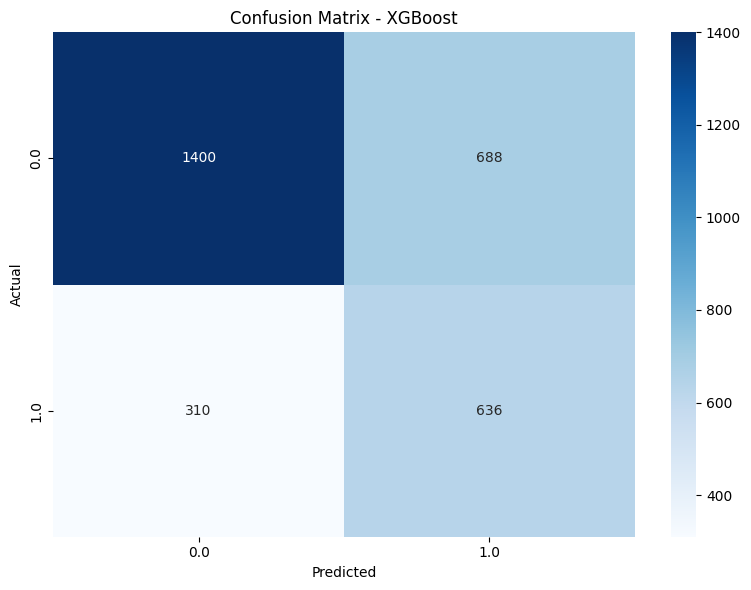


🚀 Training and Evaluating: ElasticNetLogistic


c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.50      0.63      2088
         1.0       0.42      0.80      0.55       946

    accuracy                           0.60      3034
   macro avg       0.64      0.65      0.59      3034
weighted avg       0.72      0.60      0.61      3034



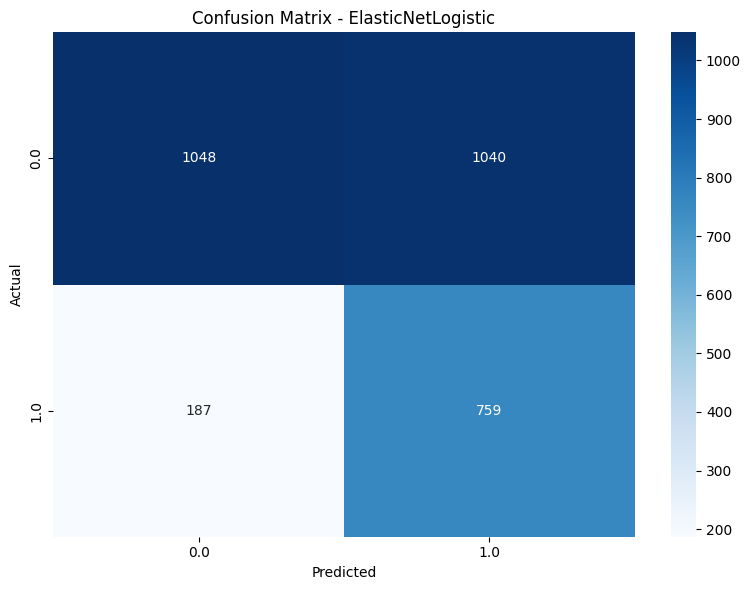


🚀 Training and Evaluating: RandomForest
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      2088
         1.0       0.54      0.49      0.51       946

    accuracy                           0.71      3034
   macro avg       0.66      0.65      0.65      3034
weighted avg       0.70      0.71      0.71      3034



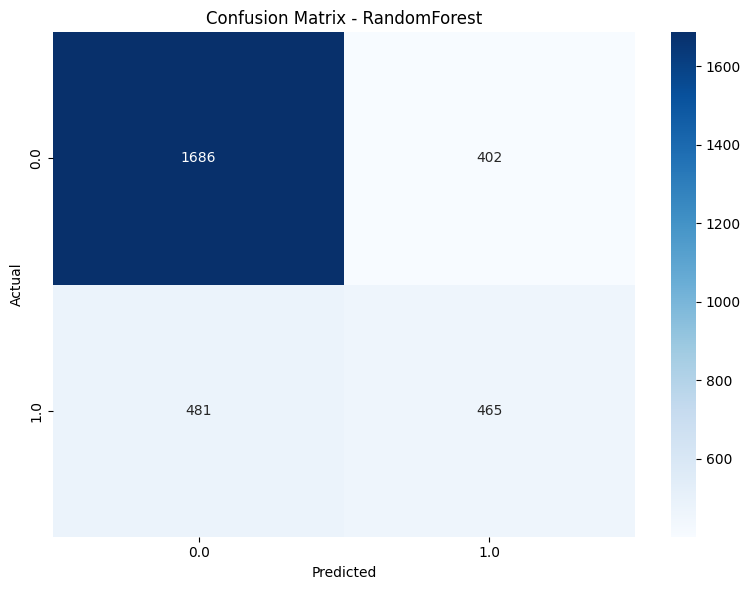


🚀 Training and Evaluating: AdaBoost
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.54      0.66      2088
         1.0       0.43      0.77      0.55       946

    accuracy                           0.61      3034
   macro avg       0.64      0.66      0.61      3034
weighted avg       0.71      0.61      0.63      3034



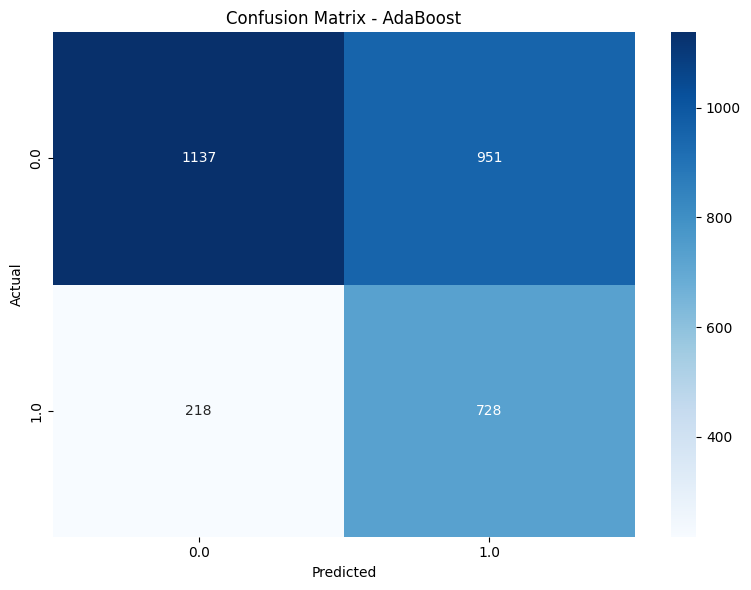


🚀 Training and Evaluating: LightGBM
[LightGBM] [Info] Number of positive: 11361, number of negative: 11361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5480
[LightGBM] [Info] Number of data points in the train set: 22722, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
✅ Saved LightGBM pipeline to 'lightgbm_pipeline.pkl'
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78      2088
         1.0       0.52      0.60      0.56       946

    accuracy                           0.70      3034
   macro avg       0.66      0.68      0.67      3034
weighted avg       0.72      0.70      0.71      3034



c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


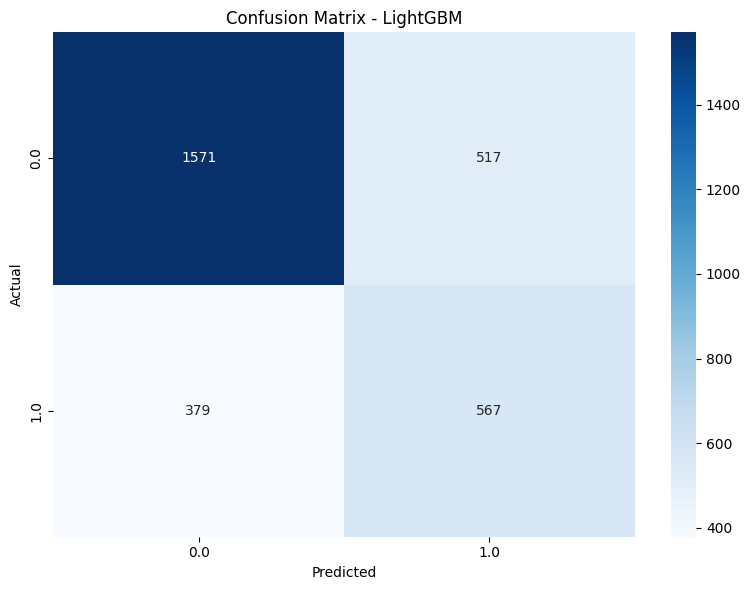

✅ Exported results to model_comparison_results.csv


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Separate features and labels
X_train_raw = df_train.drop(columns=['label'])
y_train = df_train['label']

X_test_raw = df_test.drop(columns=['label'])
y_test = df_test['label']

# Identify categorical and numeric columns
categorical_cols = ['Gender','Race', 'milk_consumption','SmokeFam']
numeric_cols = [col for col in df_train.columns if col not in categorical_cols and col !='label']
print(numeric_cols)
print(categorical_cols)
# 5. Define preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# 6. Define models
models_to_test = {
    'XGBoost': XGBClassifier(
        colsample_bytree=1.0, learning_rate=0.1, max_depth=7,
        n_estimators=50, subsample=1.0, use_label_encoder=False,
        eval_metric='mlogloss', random_state=42
    ),
    'ElasticNetLogistic': LogisticRegression(
        penalty='elasticnet', solver='saga', max_iter=1000,
        random_state=42, multi_class='multinomial', C=1.0, l1_ratio=1.0
    ),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
}


results = []

for name, model in models_to_test.items():
    print(f"\n🚀 Training and Evaluating: {name}")
    
    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
        ('classifier', model)
    ])
    
    pipe.fit(X_train_raw, y_train)


        # Lưu model LightGBM
    if name == 'LightGBM':
        # Lưu toàn bộ pipeline (bao gồm preprocessor, smote, classifier)
        joblib.dump(pipe, 'lightgbm_pipeline.pkl')
        print("✅ Saved LightGBM pipeline to 'lightgbm_pipeline.pkl'")
    y_pred = pipe.predict(X_test_raw)
    
    # Predict proba for AUC
    y_proba = pipe.predict_proba(X_test_raw)

    # Handle binary and multiclass AUC
    if len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

    # Collect scores
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Save result
    results.append({
        'Model': name,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'F1 Score (Macro)': f1,
        'Accuracy': accuracy,
        'AUC': auc
    })

    # Optional: show classification report and confusion matrix
    print("🔍 Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Export to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results.csv", index=False)
print("✅ Exported results to model_comparison_results.csv")

In [ ]:
import joblib
import pandas as pd

# Load pipeline
pipe = joblib.load('lightgbm_pipeline.pkl')

# Load dữ liệu test
df_test = pd.read_csv(r"../../data/final/08062025/processed_test.csv")
df_test = df_test[df_train.columns]
X_test_raw = df_test.drop(columns=['label'])
y_test = df_test['label']

# Dự đoán
y_pred = pipe.predict(X_test_raw)
y_proba = pipe.predict_proba(X_test_raw)

# y_proba is shape (n_samples, 2), columns are prob of class 0 and prob of class 1
# Take class 1 probability and threshold at 0.5
y_pred_manual = (y_proba[:, 1] >= 0.5).astype(int)
print(y_pred_manual)

[0 0 1 ... 0 1 0]
[[0.63519397 0.36480603]
 [0.81737626 0.18262374]
 [0.25980427 0.74019573]
 ...
 [0.85240532 0.14759468]
 [0.23015374 0.76984626]
 [0.76731036 0.23268964]]


c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


['Age', 'PIR', 'BMI', 'FastingGlucose', 'Triglycerides', 'Creatinine', 'HDLCholesterol', 'Hemoglobin', 'MeanCellVolumn', 'RedCellDistributionWidth']
['Gender', 'Race', 'milk_consumption', 'SmokeFam']

🚀 Training and Evaluating: XGBoost
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.81      2088
         1.0       0.57      0.46      0.51       946

    accuracy                           0.72      3034
   macro avg       0.67      0.65      0.66      3034
weighted avg       0.71      0.72      0.72      3034



c:\mydata\G8Vitamin\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:15:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


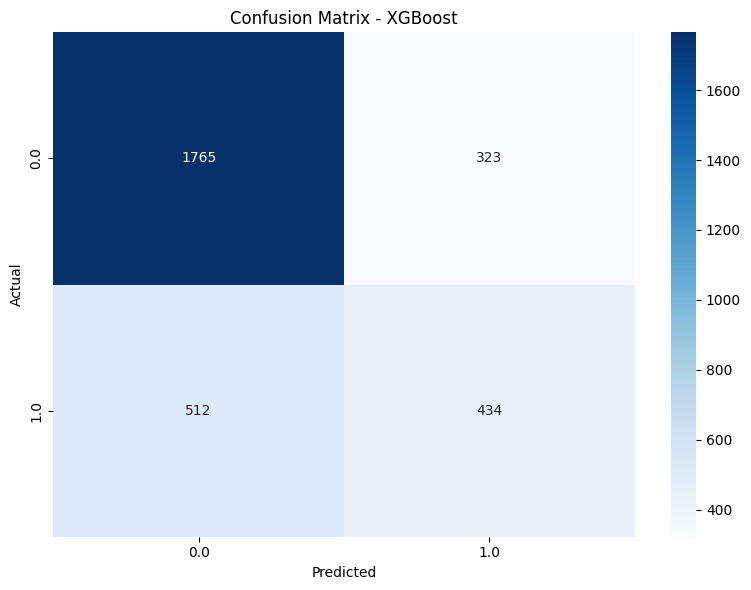

c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(



🚀 Training and Evaluating: ElasticNetLogistic
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      2088
         1.0       0.56      0.41      0.47       946

    accuracy                           0.71      3034
   macro avg       0.66      0.63      0.64      3034
weighted avg       0.70      0.71      0.70      3034



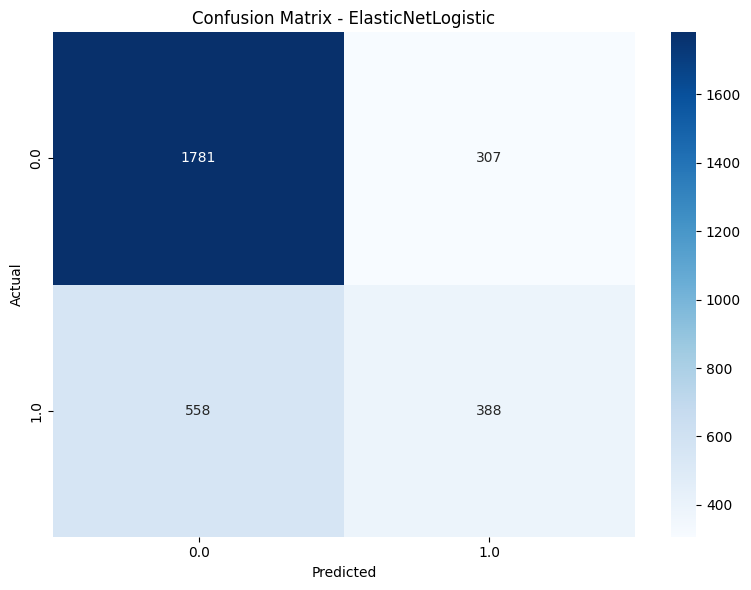


🚀 Training and Evaluating: RandomForest
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      2088
         1.0       0.60      0.32      0.42       946

    accuracy                           0.72      3034
   macro avg       0.67      0.61      0.62      3034
weighted avg       0.70      0.72      0.69      3034



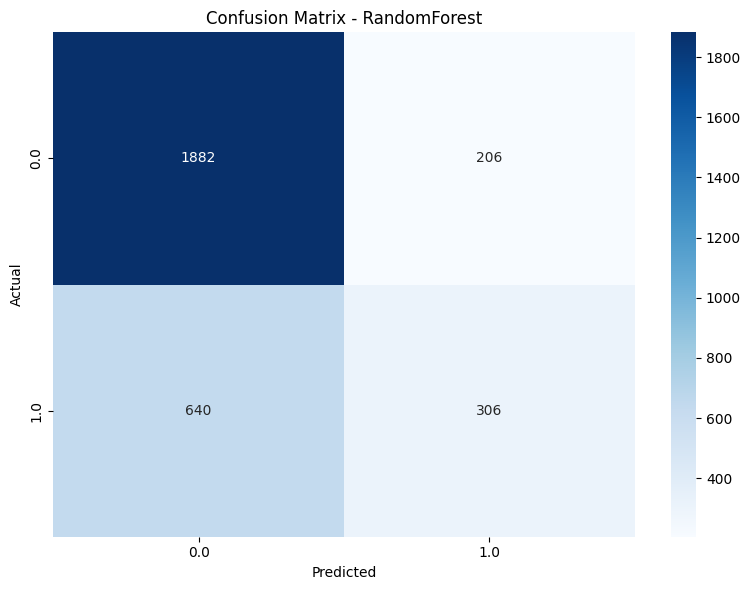


🚀 Training and Evaluating: AdaBoost
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.80      2088
         1.0       0.56      0.40      0.46       946

    accuracy                           0.71      3034
   macro avg       0.66      0.63      0.63      3034
weighted avg       0.70      0.71      0.70      3034



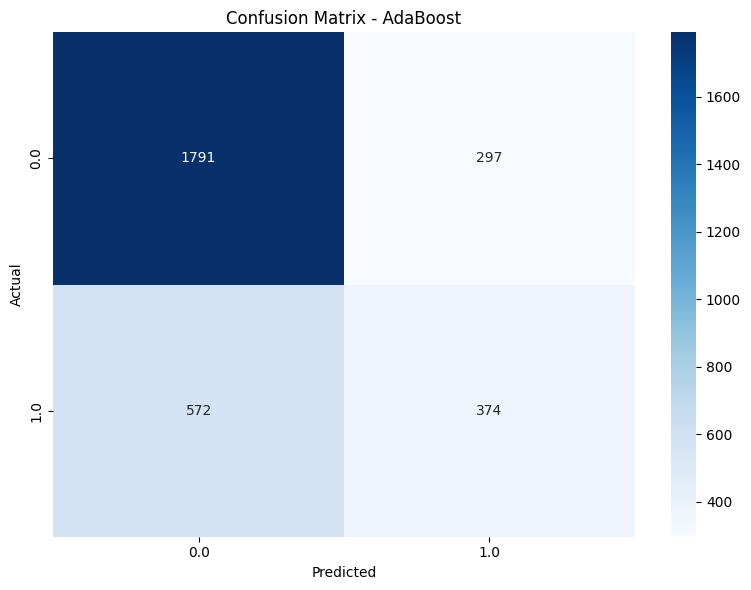


🚀 Training and Evaluating: LightGBM
[LightGBM] [Info] Number of positive: 3525, number of negative: 11361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 14886, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236800 -> initscore=-1.170306
[LightGBM] [Info] Start training from score -1.170306
✅ Saved LightGBM pipeline to 'lightgbm_pipeline.pkl'
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      2088
         1.0       0.55      0.49      0.52       946

    accuracy                           0.72      3034
   macro avg       0.67      0.65      0.66      3034
weighted avg       0.71      0.72      0.71      3034



c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


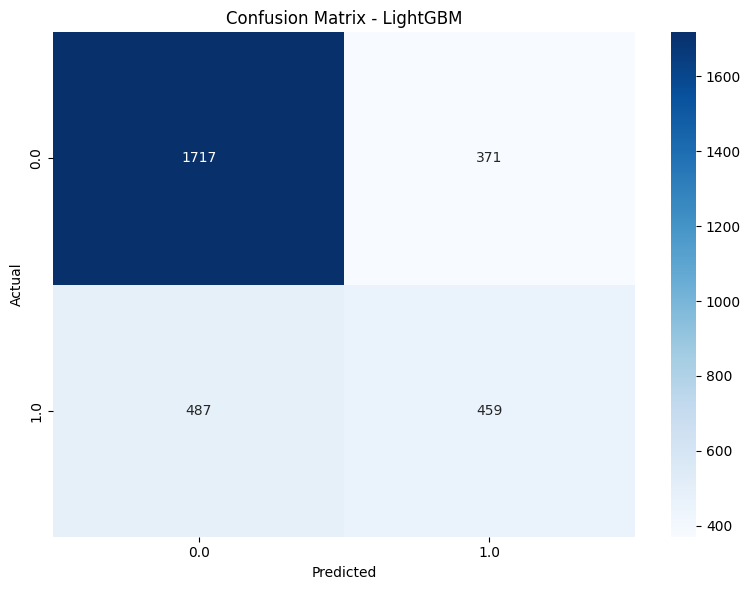

✅ Exported results to model_comparison_results.csv


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Separate features and labels
X_train_raw = df_train.drop(columns=['label'])
y_train = df_train['label']

X_test_raw = df_test.drop(columns=['label'])
y_test = df_test['label']

# Identify categorical and numeric columns
categorical_cols = ['Gender','Race', 'milk_consumption','SmokeFam']
numeric_cols = [col for col in df_train.columns if col not in categorical_cols and col !='label']
print(numeric_cols)
print(categorical_cols)
# 5. Define preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# 6. Define models
models_to_test = {
    'XGBoost': XGBClassifier(
        colsample_bytree=1.0, learning_rate=0.1, max_depth=7,
        n_estimators=50, subsample=1.0, use_label_encoder=False,
        eval_metric='mlogloss', random_state=42
    ),
    'ElasticNetLogistic': LogisticRegression(
        penalty='elasticnet', solver='saga', max_iter=1000,
        random_state=42, multi_class='multinomial', C=1.0, l1_ratio=1.0
    ),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
}


results = []

for name, model in models_to_test.items():
    print(f"\n🚀 Training and Evaluating: {name}")
    
    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipe.fit(X_train_raw, y_train)


        # Lưu model LightGBM
    if name == 'LightGBM':
        # Lưu toàn bộ pipeline (bao gồm preprocessor, smote, classifier)
        joblib.dump(pipe, 'lightgbm_pipeline.pkl')
        print("✅ Saved LightGBM pipeline to 'lightgbm_pipeline.pkl'")
    y_pred = pipe.predict(X_test_raw)
    
    # Predict proba for AUC
    y_proba = pipe.predict_proba(X_test_raw)

    # Handle binary and multiclass AUC
    if len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

    # Collect scores
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Save result
    results.append({
        'Model': name,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'F1 Score (Macro)': f1,
        'Accuracy': accuracy,
        'AUC': auc
    })

    # Optional: show classification report and confusion matrix
    print("🔍 Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Export to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results_notsmote.csv", index=False)
print("✅ Exported results to model_comparison_results.csv")

In [30]:
df_train.columns

Index(['Gender', 'Age', 'Race', 'PIR', 'BMI', 'FastingGlucose',
       'Triglycerides', 'Creatinine', 'HDLCholesterol', 'Hemoglobin',
       'MeanCellVolumn', 'RedCellDistributionWidth', 'SmokeFam',
       'milk_consumption', 'label'],
      dtype='object')

[LightGBM] [Info] Number of positive: 3525, number of negative: 11361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 14886, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.236800 -> initscore=-1.170306
[LightGBM] [Info] Start training from score -1.170306


c:\mydata\G8Vitamin\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


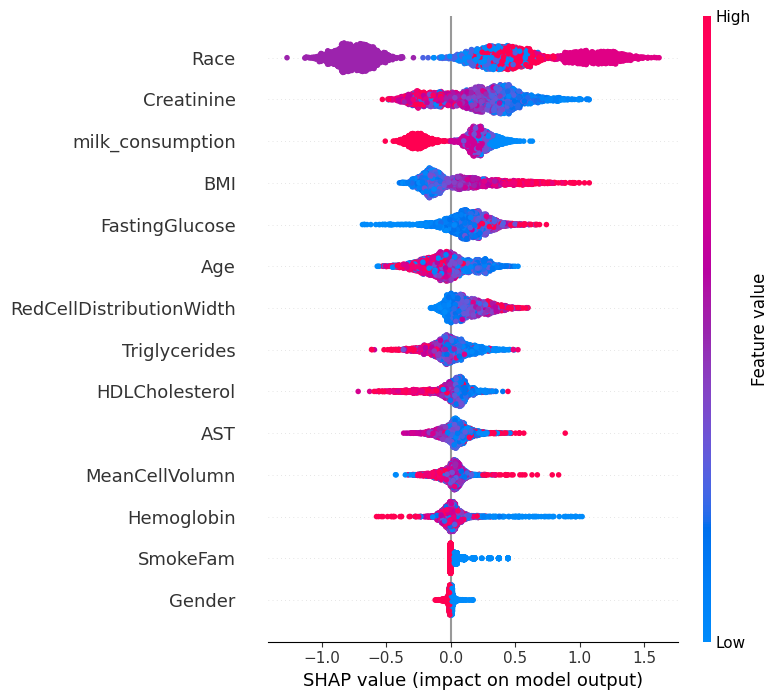

In [103]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Tiền xử lý dữ liệu
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

# Chuyển sparse matrix sang dense nếu cần
X_test_dense = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

# Huấn luyện lại mô hình
lgbm_model = models_to_test['LightGBM']
lgbm_model.fit(X_train_processed, y_train)

# Tạo SHAP explainer và tính giá trị SHAP
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test_dense)

# Lấy tên feature sau OneHotEncoder
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(onehot_feature_names) + numeric_cols

# Tạo DataFrame SHAP
shap_df = pd.DataFrame(shap_values[1] if isinstance(shap_values, list) else shap_values, columns=all_feature_names)

# ✅ Gộp SHAP theo đặc trưng gốc nhưng KHÔNG dùng abs()
def aggregate_shap_preserve_sign(shap_df, original_cat_cols, numeric_cols):
    aggregated = pd.DataFrame()
    for col in original_cat_cols:
        matching_cols = [c for c in shap_df.columns if c.startswith(col + "_")]
        aggregated[col] = shap_df[matching_cols].sum(axis=1)  # ✅ giữ giá trị âm/dương
    for col in numeric_cols:
        aggregated[col] = shap_df[col]  # giữ nguyên giá trị số
    return aggregated

# Gộp SHAP và dữ liệu gốc để truyền vào summary_plot
shap_agg = aggregate_shap_preserve_sign(shap_df, categorical_cols, numeric_cols)
X_test_original = X_test_raw[categorical_cols + numeric_cols].reset_index(drop=True)

# ✅ Vẽ biểu đồ SHAP với chiều ảnh hưởng âm/dương
shap.summary_plot(shap_agg.values, features=X_test_original, feature_names=shap_agg.columns)


## Error Analysis

[LightGBM] [Info] Number of positive: 11361, number of negative: 11361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4875
[LightGBM] [Info] Number of data points in the train set: 22722, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75      2088
         1.0       0.49      0.63      0.55       946

    accuracy                           0.68      3034
   macro avg       0.65      0.67      0.65      3034
weighted avg       0.71      0.68      0.69      3034



c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\mydata\G8Vitamin\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


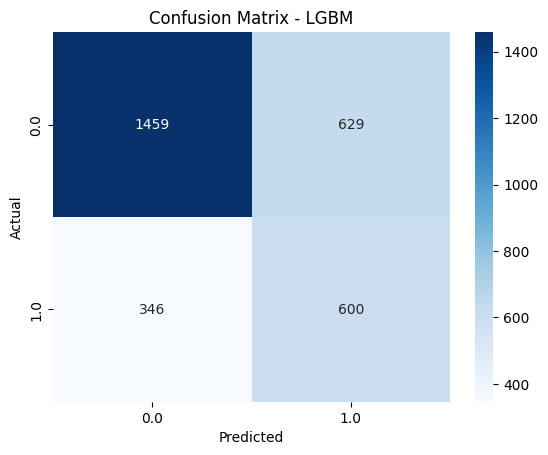


🔍 Error counts by Age:
error_type  Correct  False Negative  False Positive
Age                                                
12.0             40               9              10
13.0             43              17              13
14.0             46               4              14
15.0             46               9              12
16.0             48              15              15
...             ...             ...             ...
76.0             17               1               2
77.0             16               1               5
78.0             15               3               2
79.0              9               0               4
80.0            103              14              19

[69 rows x 3 columns]

🔍 Error counts by Race:
error_type  Correct  False Negative  False Positive
Race                                               
1.0             250              64             118
2.0             187              48              46
3.0             913             140         

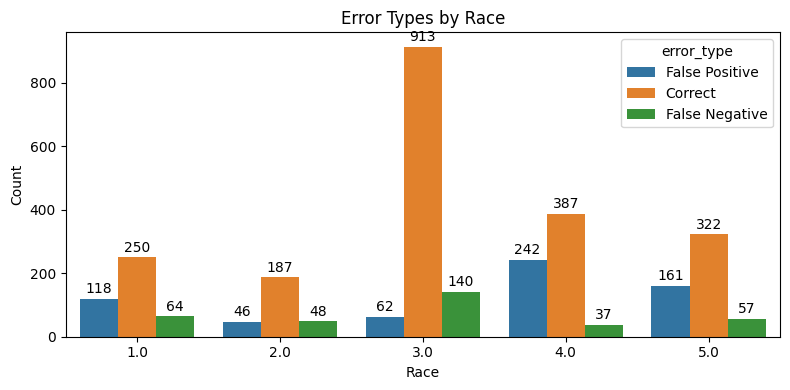


🔍 Error counts by milk_consumption:
error_type        Correct  False Negative  False Positive
milk_consumption                                         
5.397605e-79          378              70             138
1.000000e+00          394              74             149
2.000000e+00          602              75             205
3.000000e+00          685             127             137


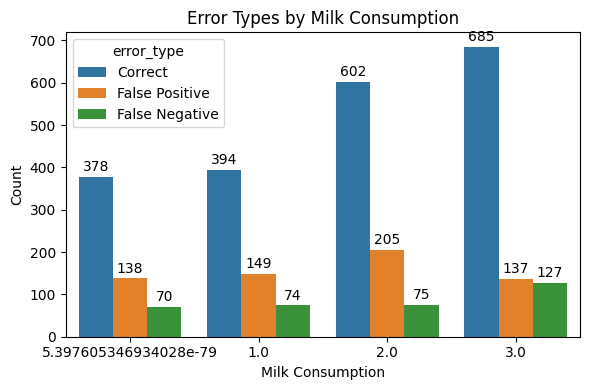


🔍 Error counts by Age Group (optimized bins):
error_type  Correct  False Negative  False Positive
age_group                                          
<20 tuổi        350              70              90
20–35 tuổi      414              66             162
36–50 tuổi      391              66             138
51–65 tuổi      508              91             152
66+ tuổi        396              53              87


C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\1620018460.py:136: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_errors.groupby(['age_group', 'error_type']).size().unstack(fill_value=0))


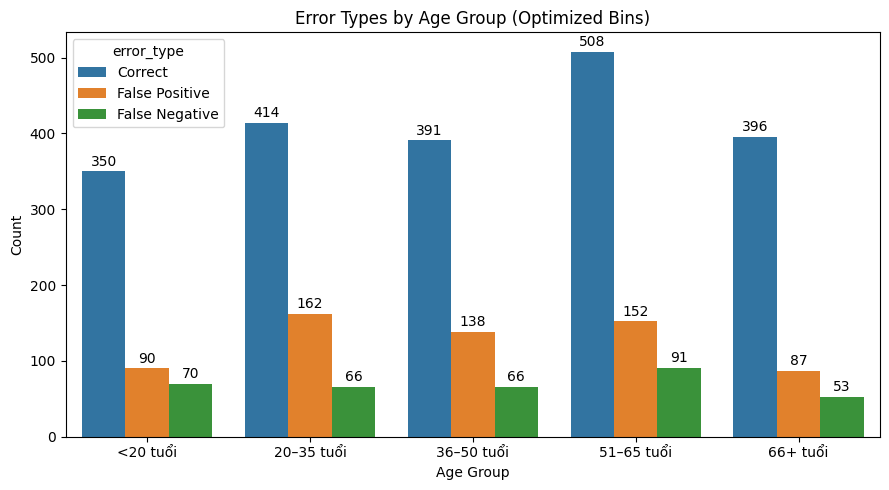


📊 Tỷ lệ lỗi theo nhóm tuổi (đơn vị: %) :
error_type  Correct (%)  False Positive (%)  False Negative (%)
age_group                                                      
<20 tuổi          68.63               17.65               13.73
20–35 tuổi        64.49               25.23               10.28
36–50 tuổi        65.71               23.19               11.09
51–65 tuổi        67.64               20.24               12.12
66+ tuổi          73.88               16.23                9.89


C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\1620018460.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_counts = df_errors.groupby(['age_group', 'error_type']).size().unstack(fill_value=0)


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier

# --- 1. Prepare data
X_train_raw = df_train.drop(columns=['label'])
y_train = df_train['label']
X_test_raw = df_test.drop(columns=['label'])
y_test = df_test['label']

# --- 2. Column definitions
categorical_cols = ['Race', 'milk_consumption']
numeric_cols = [col for col in df_train.columns if col not in categorical_cols and col != 'label']

# --- 3. Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# --- 4. LGBM pipeline with SMOTE
lgbm_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('classifier', LGBMClassifier(random_state=42))
])

# --- 5. Fit and predict
lgbm_pipe.fit(X_train_raw, y_train)
y_pred = lgbm_pipe.predict(X_test_raw)
y_proba = lgbm_pipe.predict_proba(X_test_raw)[:, 1]

# --- 6. Evaluation
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0.0, 1.0], yticklabels=[0.0, 1.0])
plt.title("Confusion Matrix - LGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 7. Attach predictions to test set
df_errors = X_test_raw.copy()
df_errors['true_label'] = y_test.values
df_errors['predicted_label'] = y_pred
df_errors['proba_class1'] = y_proba

# --- 8. Mark error types
df_errors['error_type'] = np.where(
    (df_errors['true_label'] == 1) & (df_errors['predicted_label'] == 0), 'False Negative',
    np.where((df_errors['true_label'] == 0) & (df_errors['predicted_label'] == 1), 'False Positive', 'Correct')
)

# --- 9. Error counts by categorical feature
age_error_counts = df_errors.groupby(['Age', 'error_type']).size().unstack(fill_value=0)
print("\n🔍 Error counts by Age:")
print(age_error_counts)

race_error_counts = df_errors.groupby(['Race', 'error_type']).size().unstack(fill_value=0)
print("\n🔍 Error counts by Race:")
print(race_error_counts)

plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_errors, x='Race', hue='error_type')
plt.title('Error Types by Race')
plt.ylabel('Count')
plt.xlabel('Race')

# Thêm số lượng trên từng cột
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)

plt.tight_layout()
plt.show()


milk_error_counts = df_errors.groupby(['milk_consumption', 'error_type']).size().unstack(fill_value=0)
print("\n🔍 Error counts by milk_consumption:")
print(milk_error_counts)

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_errors, x='milk_consumption', hue='error_type')
plt.title('Error Types by Milk Consumption')
plt.ylabel('Count')
plt.xlabel('Milk Consumption')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)

plt.tight_layout()
plt.show()

# # --- 10. Compare numeric features
# numeric_features = ['BMI', 'FastingGlucose', 'ALT', 'Triglycerides',
#                     'Creatinine', 'HDLCholesterol', 'Hemoglobin',
#                     'MeanCellVolumn', 'RedCellDistributionWidth']

# print("\n🔍 Mean of numeric features by error type:\n")
# print(df_errors.groupby('error_type')[numeric_features].mean())

# # --- 11. Boxplot for each numeric feature
# for feature in numeric_features:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x='error_type', y=feature, data=df_errors)
#     plt.title(f'{feature} by Error Type')
#     plt.tight_layout()
#     plt.show()

# --- 12. Age Grouping & Error Analysis
age_bins = [0, 30, 45, 60, 120]
age_labels = ['18-30', '31-45', '46-60', '60+']
df_errors['age_group'] = pd.cut(df_errors['Age'], bins=age_bins, labels=age_labels, right=False)

# --- 13. Error summary by age group
# --- Cập nhật nhóm tuổi theo phân loại mới
# Gộp lại nhóm tuổi để dễ phân tích
age_bins = [0, 20, 36, 51, 66, np.inf]
age_labels = ['<20 tuổi', '20–35 tuổi', '36–50 tuổi', '51–65 tuổi', '66+ tuổi']

df_errors['age_group'] = pd.cut(df_errors['Age'], bins=age_bins, labels=age_labels, right=False)

# Thống kê lại lỗi
print("\n🔍 Error counts by Age Group (optimized bins):")
print(df_errors.groupby(['age_group', 'error_type']).size().unstack(fill_value=0))

# Vẽ biểu đồ mới
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=df_errors, x='age_group', hue='error_type')
plt.title('Error Types by Age Group (Optimized Bins)')
plt.ylabel('Count')
plt.xlabel('Age Group')

# Gắn số lượng lên các cột
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)

plt.tight_layout()
plt.show()

# --- Đếm số lượng theo nhóm tuổi và loại lỗi
error_counts = df_errors.groupby(['age_group', 'error_type']).size().unstack(fill_value=0)

# --- Tính tổng số mẫu trong từng nhóm tuổi
error_counts['Total'] = error_counts.sum(axis=1)

# --- Tính % lỗi
error_counts['False Positive (%)'] = (error_counts['False Positive'] / error_counts['Total'] * 100).round(2)
error_counts['False Negative (%)'] = (error_counts['False Negative'] / error_counts['Total'] * 100).round(2)
error_counts['Correct (%)'] = (error_counts['Correct'] / error_counts['Total'] * 100).round(2)

# --- Hiển thị bảng phân tích
print("\n📊 Tỷ lệ lỗi theo nhóm tuổi (đơn vị: %) :")
print(error_counts[['Correct (%)', 'False Positive (%)', 'False Negative (%)']])




In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Danh sách nhóm tuổi
age_groups = df_errors['age_group'].unique()

# Tạo bảng lưu kết quả
f1_table = []

for group in age_groups:
    subset = df_errors[df_errors['age_group'] == group]
    y_true = subset['true_label']
    y_pred = subset['predicted_label']
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    f1_table.append({
        'Age Group': group,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3),
        'Samples': len(subset)
    })

# Hiển thị dưới dạng DataFrame
f1_df = pd.DataFrame(f1_table).sort_values(by='F1 Score', ascending=False)
print("\n📊 F1-score và các chỉ số theo nhóm tuổi:")
print(f1_df)



📊 F1-score và các chỉ số theo nhóm tuổi:
    Age Group  Precision  Recall  F1 Score  Samples
3  20–35 tuổi      0.567   0.763     0.650      642
4    <20 tuổi      0.583   0.643     0.612      510
2  36–50 tuổi      0.485   0.663     0.560      595
0  51–65 tuổi      0.397   0.524     0.451      751
1    66+ tuổi      0.269   0.376     0.314      536


C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\4102137785.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=f1_df, x='Age Group', y='F1 Score', order=age_order, palette='viridis')


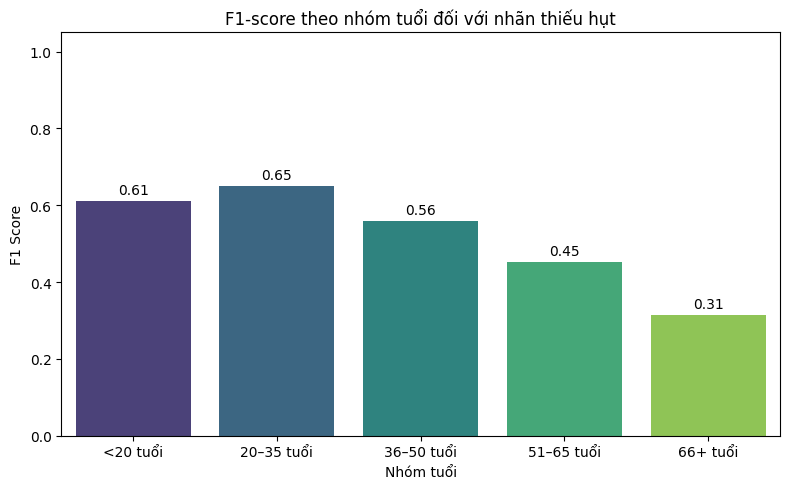

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Đảm bảo thứ tự nhóm tuổi
age_order = ['<20 tuổi', '20–35 tuổi', '36–50 tuổi', '51–65 tuổi', '66+ tuổi']

f1_table = []

for group in age_order:
    subset = df_errors[df_errors['age_group'] == group]
    y_true = subset['true_label']
    y_pred = subset['predicted_label']
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    f1_table.append({
        'Age Group': group,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Samples': len(subset)
    })

f1_df = pd.DataFrame(f1_table)


# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
sns.barplot(data=f1_df, x='Age Group', y='F1 Score', order=age_order, palette='viridis')

# Thêm nhãn giá trị trên mỗi cột
for index, row in f1_df.iterrows():
    plt.text(index, row['F1 Score'] + 0.01, f"{row['F1 Score']:.2f}", ha='center', va='bottom')

plt.title("F1-score theo nhóm tuổi đối với nhãn thiếu hụt")
plt.ylabel("F1 Score")
plt.xlabel("Nhóm tuổi")
plt.ylim(0, 1.05)  # Giới hạn trục y từ 0 đến 1.05 để dễ nhìn
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
from sklearn.metrics import f1_score

# Giả sử bạn đã có df_errors chứa: 'age_group', 'true_label', 'predicted_label'
age_order = ['<20 tuổi', '20–35 tuổi', '36–50 tuổi', '51–65 tuổi', '66+ tuổi']

macro_f1_table = []

for group in age_order:
    subset = df_errors[df_errors['age_group'] == group]
    y_true = subset['true_label']
    y_pred = subset['predicted_label']
    
    # Macro F1 = trung bình F1 của từng class (0, 1)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    macro_f1_table.append({
        'Age Group': group,
        'Macro F1 Score': macro_f1,
        'Samples': len(subset)
    })

macro_f1_df = pd.DataFrame(macro_f1_table)
print(macro_f1_df)


    Age Group  Macro F1 Score  Samples
0    <20 tuổi        0.674246      510
1  20–35 tuổi        0.644774      642
2  36–50 tuổi        0.639677      595
3  51–65 tuổi        0.611003      751
4    66+ tuổi        0.576218      536


C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\3826659596.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=macro_f1_df, x='Age Group', y='Macro F1 Score', order=age_order, palette='magma')


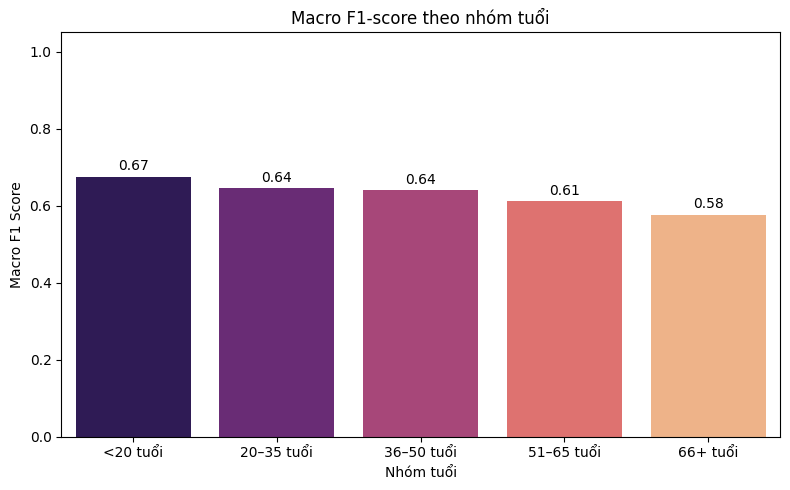

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=macro_f1_df, x='Age Group', y='Macro F1 Score', order=age_order, palette='magma')

for index, row in macro_f1_df.iterrows():
    plt.text(index, row['Macro F1 Score'] + 0.01, f"{row['Macro F1 Score']:.2f}", ha='center', va='bottom')

plt.title("Macro F1-score theo nhóm tuổi")
plt.ylabel("Macro F1 Score")
plt.xlabel("Nhóm tuổi")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


In [36]:
# Tạo bảng phân tích kết hợp milk_consumption và age_group
milk_age_counts = df_errors.groupby(['age_group', 'milk_consumption', 'error_type']).size().unstack(fill_value=0)

print("\n🍼 Phân tích lỗi theo milk_consumption và nhóm tuổi:")
display(milk_age_counts)

# Tạo bảng phân tích kết hợp Race và age_group
race_age_counts = df_errors.groupby(['age_group', 'Race', 'error_type']).size().unstack(fill_value=0)

print("\n🎭 Phân tích lỗi theo Race và nhóm tuổi:")
display(race_age_counts)



🍼 Phân tích lỗi theo milk_consumption và nhóm tuổi:


C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\167525807.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  milk_age_counts = df_errors.groupby(['age_group', 'milk_consumption', 'error_type']).size().unstack(fill_value=0)


error_type                   Correct  False Negative  False Positive
age_group  milk_consumption                                         
<20 tuổi   5.397605e-79           24               6               2
           1.000000e+00           54               9              14
           2.000000e+00          103              20              30
           3.000000e+00          169              35              44
20–35 tuổi 5.397605e-79           96               8              35
           1.000000e+00           92              17              39
           2.000000e+00          117              15              55
           3.000000e+00          109              26              33
36–50 tuổi 5.397605e-79           78              14              39
           1.000000e+00           82              13              36
           2.000000e+00          117              18              40
           3.000000e+00          114              21              23
51–65 tuổi 5.397605e-79          102              30              39
           1.000000e+00          114              21              46
           2.000000e+00          146              10              47
           3.000000e+00          146              30              20
66+ tuổi   5.397605e-79           78              12              23
           1.000000e+00           52              14              14
           2.000000e+00          119              12              33
           3.000000e+00          147              15              17


🎭 Phân tích lỗi theo Race và nhóm tuổi:


C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\167525807.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_age_counts = df_errors.groupby(['age_group', 'Race', 'error_type']).size().unstack(fill_value=0)


error_type       Correct  False Negative  False Positive
age_group  Race                                         
<20 tuổi   1.0        49              18              35
           2.0        19               7               8
           3.0       160              24               1
           4.0        68               8              20
           5.0        54              13              26
20–35 tuổi 1.0        64              12              22
           2.0        24               5              22
           3.0       158              34              22
           4.0       107               6              44
           5.0        61               9              52
36–50 tuổi 1.0        47              10              32
           2.0        34              12               9
           3.0       165              27              18
           4.0        69               3              43
           5.0        76              14              36
51–65 tuổi 1.0        59              15              23
           2.0        78              15               6
           3.0       199              31               9
           4.0        94              11              79
           5.0        78              19              35
66+ tuổi   1.0        31               9               6
           2.0        32               9               1
           3.0       231              24              12
           4.0        49               9              56
           5.0        53               2              12

C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\3874764405.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby('Nhóm tuổi').size()


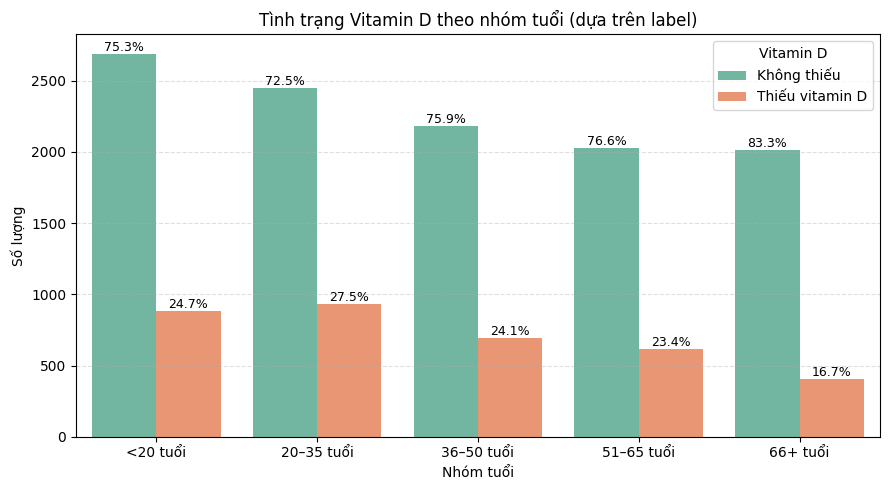

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = df_train.copy()
# Nhóm tuổi mới
age_bins = [0, 20, 36, 51, 66, np.inf]
age_labels = ['<20 tuổi', '20–35 tuổi', '36–50 tuổi', '51–65 tuổi', '66+ tuổi']

# Đảm bảo đã phân nhóm tuổi mới
df['Nhóm tuổi'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Tạo cột trạng thái vitamin D dạng text từ label 0/1
df['Tình trạng Vitamin D'] = df['label'].apply(lambda x: 'Thiếu vitamin D' if x == 1 else 'Không thiếu')

# Vẽ biểu đồ đếm số lượng theo nhóm tuổi mới và label
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=df, x='Nhóm tuổi', hue='Tình trạng Vitamin D', palette='Set2')

plt.title('Tình trạng Vitamin D theo nhóm tuổi (dựa trên label)')
plt.xlabel('Nhóm tuổi')
plt.ylabel('Số lượng')
plt.legend(title='Vitamin D')
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

# Tính tổng số lượng theo nhóm tuổi
total_counts = df.groupby('Nhóm tuổi').size()

# Thêm phần trăm trên mỗi cột
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        x_pos = p.get_x()
        width = p.get_width()
        idx = int(round(x_pos + width / 2))
        group = ax.get_xticklabels()[idx].get_text()

        total = total_counts[group]
        percent = height / total * 100
        ax.text(
            p.get_x() + width / 2,
            height,
            f'{percent:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()


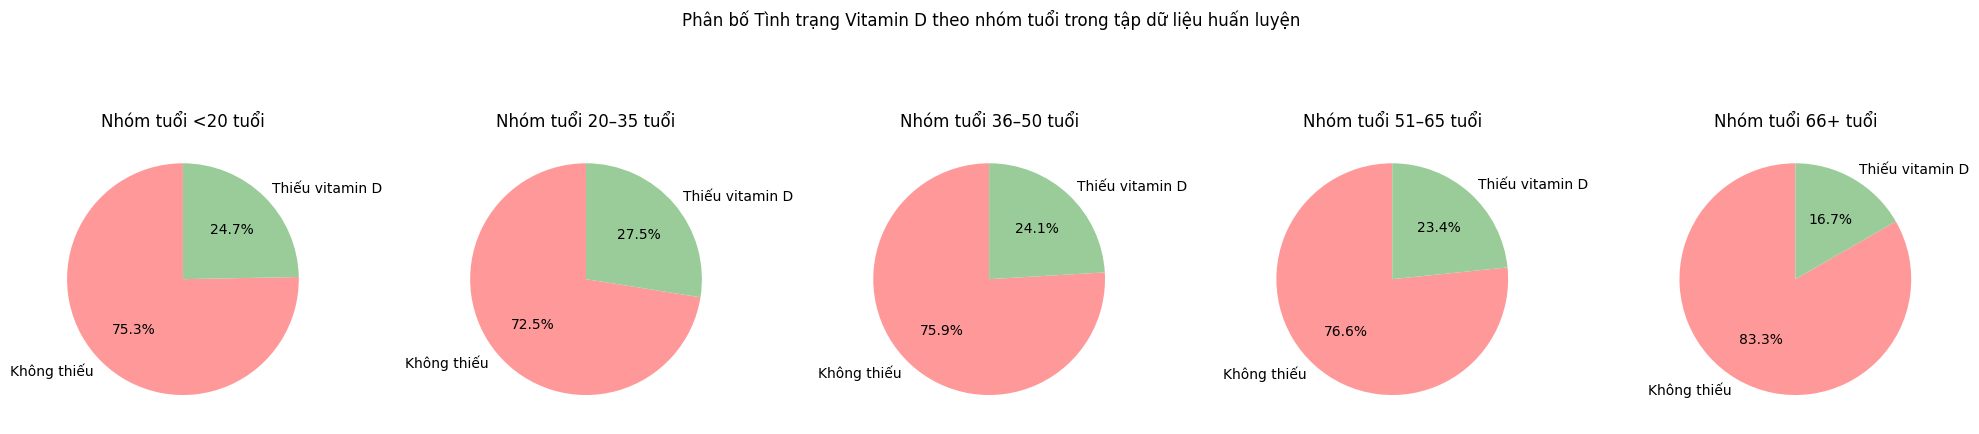

In [38]:
import matplotlib.pyplot as plt

# Nhóm tuổi mới
age_bins = [0, 20, 36, 51, 66, np.inf]
age_labels = ['<20 tuổi', '20–35 tuổi', '36–50 tuổi', '51–65 tuổi', '66+ tuổi']

# Phân nhóm tuổi mới
df['Nhóm tuổi'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Chuyển label thành text để dễ nhìn
df['Tình trạng Vitamin D'] = df['label'].apply(lambda x: 'Thiếu vitamin D' if x == 1 else 'Không thiếu')

# Tạo biểu đồ hình tròn cho từng nhóm tuổi
fig, axes = plt.subplots(1, len(age_labels), figsize=(20, 5))

for ax, group in zip(axes, age_labels):
    data_group = df[df['Nhóm tuổi'] == group]['Tình trạng Vitamin D'].value_counts()
    labels = data_group.index
    sizes = data_group.values

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#99cc99'])
    ax.set_title(f'Nhóm tuổi {group}')

plt.suptitle('Phân bố Tình trạng Vitamin D theo nhóm tuổi trong tập dữ liệu huấn luyện')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


📊 Số lượng mẫu theo nhóm tuổi và chủng tộc:
Race         1.0  2.0   3.0   4.0  5.0
age_group                             
<20 tuổi    1019  207  1066  1048  234
20–35 tuổi   743  241  1453   676  265
36–50 tuổi   494  214  1395   549  219
51–65 tuổi   453  205  1265   545  175
66+ tuổi     303  138  1561   329   89


C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\115837645.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_race_counts = df_train.groupby(['age_group', 'Race']).size().unstack(fill_value=0)
C:\Users\iseT1enLoc\AppData\Local\Temp\ipykernel_2560\115837645.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df_train.groupby(['age_group', 'Race']).size().reset_index(name='count')


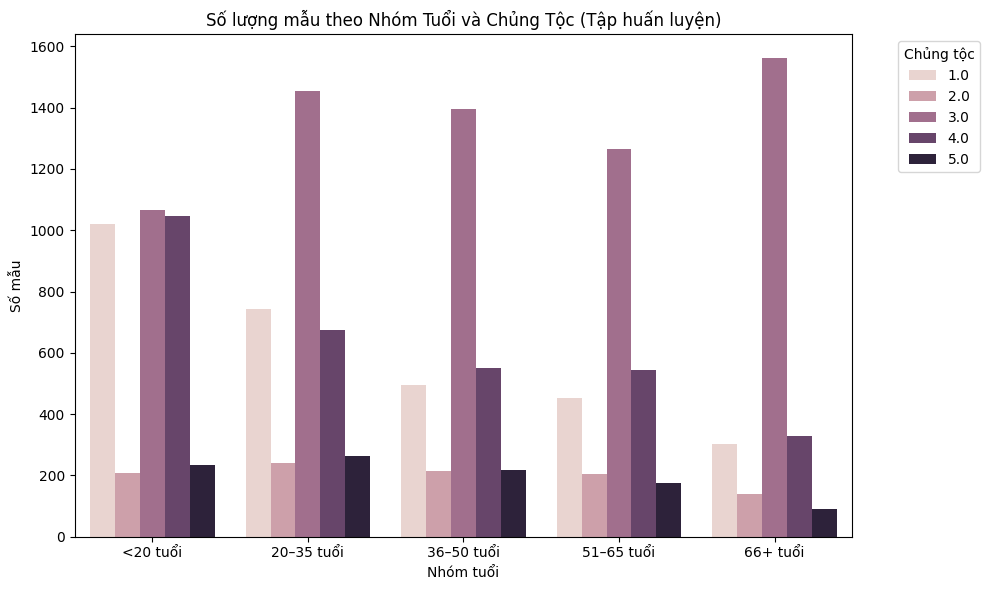

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Tạo nhóm tuổi (Age Group) trong df_train
age_bins = [0, 20, 36, 51, 66, float('inf')]
age_labels = ['<20 tuổi', '20–35 tuổi', '36–50 tuổi', '51–65 tuổi', '66+ tuổi']

# Thêm cột nhóm tuổi
df_train['age_group'] = pd.cut(df_train['Age'], bins=age_bins, labels=age_labels, right=False)

# --- 2. Thống kê số lượng mẫu theo nhóm tuổi và chủng tộc
age_race_counts = df_train.groupby(['age_group', 'Race']).size().unstack(fill_value=0)

print("📊 Số lượng mẫu theo nhóm tuổi và chủng tộc:")
print(age_race_counts)

# --- 3. Trực quan hóa dữ liệu: Stacked Bar Chart
df_plot = df_train.groupby(['age_group', 'Race']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='age_group', y='count', hue='Race')
plt.title("Số lượng mẫu theo Nhóm Tuổi và Chủng Tộc (Tập huấn luyện)")
plt.ylabel("Số mẫu")
plt.xlabel("Nhóm tuổi")
plt.legend(title="Chủng tộc", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
